# Modelagem Estatística - Sobredispersão em Modelos de Contagem
**Aluno**: Pedro Santos Tokar | **Curso**: Ciência de Dados e Inteligência Artificial, 5º período | **Matrícula**: 231708008

## Introdução
Este documento é referente ao trabalho auxiliar passado na matéria de Modelagem Estatística, ofertada na FGV - EMAp. A motivação do trabalho é ter uma experiência prática com o ajuste de modelos estatísticos (mais específicamente, o GLM Poisson). Durante o desenvolvimento deste trabalho, uma base de dados reais será analisada e diferentes modelos estatísticos serão ajustados aos dados desta base. Os resultados de cada modelo serão discutidos e usados para exemplificar conceitos conhecidos da modelagem estatística.

In [1]:
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.eval_measures import aic

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import matplotlib
import seaborn as sns

plt.rcParams["patch.edgecolor"] = "black"
plt.rcParams["patch.linewidth"] = 1
plt.rcParams["patch.force_edgecolor"] = True
plt.rcParams["axes.labelsize"] = "large"
plt.rcParams["xtick.labelsize"]  = "large"
plt.rcParams["ytick.labelsize"]  = "large"

## 1. Entendendo os dados

Iremos trabalhar com a base de dados *RecreationDemand*, disponível no pacote `Applied Econometrics with R`. Ela contém informações sobre o número de viagens recreativas de barco para o Lago Somerville que foram feitas por donos de barcos de lazer no leste do Texas, em 1980. O dataset conta com 8 variáveis, e iremos analisar cada uma para entender seu significado.

In [2]:
dados = pd.read_csv("RecreationDemand.csv")
dados.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 659 entries, 0 to 658
Data columns (total 8 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   trips    659 non-null    int64  
 1   quality  659 non-null    int64  
 2   ski      659 non-null    object 
 3   income   659 non-null    int64  
 4   userfee  659 non-null    object 
 5   costC    659 non-null    float64
 6   costS    659 non-null    float64
 7   costH    659 non-null    float64
dtypes: float64(3), int64(3), object(2)
memory usage: 41.3+ KB


A primeira variável é a `trips`. Ela representa a quantidade de passeios de barco que os proprietários fizeram para o Lago Sommervile, e é a nossa **variável dependente**, pois é ela que temos interesse em regredir. A utilidade dessa regressão está em entender que fatores (principalmente econômicos) podem ou não influenciar a decisão de uma pessoa de visitar ou não o lago a passeio.

In [3]:
f"Média: {float(dados['trips'].mean())} | Mediana: {float(dados['trips'].median())} | Variância: {float(dados['trips'].var())} | Desvio Padrão: {float(dados['trips'].std())}"

'Média: 2.244309559939302 | Mediana: 0.0 | Variância: 39.59523732651941 | Desvio Padrão: 6.292474658393104'

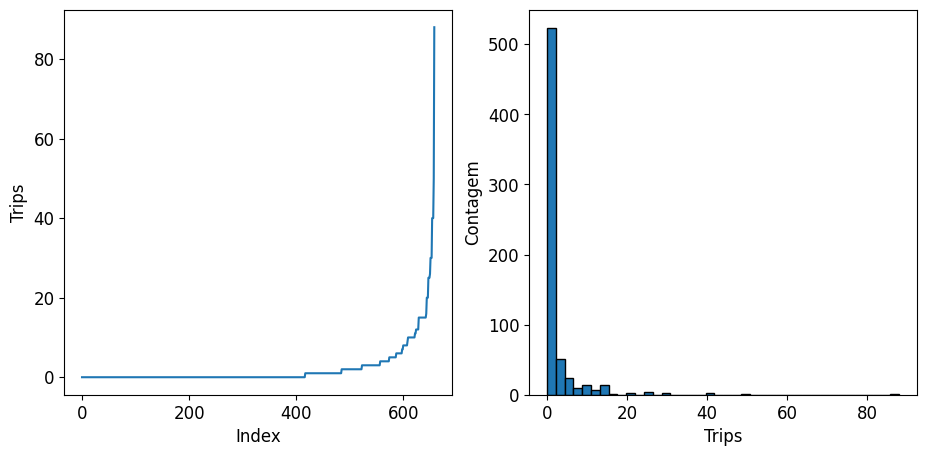

In [4]:
fig, axs = plt.subplots(1, 2, figsize = (11, 5))
axs[0].plot(dados["trips"])
axs[1].hist(dados["trips"], bins = 40)

axs[0].set_xlabel("Index")
axs[0].set_ylabel("Trips")
axs[1].set_xlabel("Trips")
axs[1].set_ylabel("Contagem");

Percebemos aqui que o dataset está ordenado seguindo essa variável, e que ela contém apenas observações positivas, como o esperado. Sua média é 2,24 viagens e sua variância é 39. Notamos logo de cara que, de quase 700 registros, mais de 400 deles tem valores 0. Para observar melhor a distribuição da variável, é possível plotar ignorando valores 0:

In [5]:
f"Contagem de 0s: {dados['trips'].value_counts()[0]}"

'Contagem de 0s: 417'

Text(0, 0.5, 'Trips')

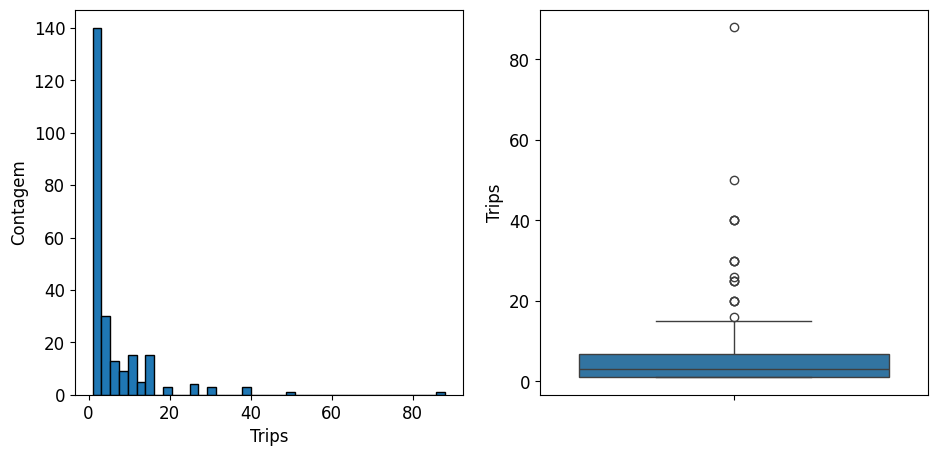

In [6]:
fig, axs = plt.subplots(1, 2, figsize = (11, 5))
axs[0].hist(dados.loc[dados["trips"] != 0, "trips"], bins = 40)
sns.boxplot(dados[dados["trips"] != 0], y = "trips", ax = axs[1])

axs[0].set_xlabel("Trips")
axs[0].set_ylabel("Contagem")
axs[1].set_ylabel("Trips")

Observamos que a grande maioria dos valores está abaixo de 20, com números menores de observações com valores mais altos, o valor máximo na casa do 80 (perto de alcançar a terceira casa decimal). Essa característica, aliada ao fato do domínio da variável ser os números naturais, torna adequado o uso de modelos como o de Poisson, que é capaz de modelar dados de contagens. Mais da metade das observações ser 0 pode ser um problema para a regressão, mas a principio isso será ignorado.

A segunda variável do dataset é a `quality`. Ao contrário da maioria das **variáveis independentes** do dataset, ela não é relacionada a um indicador econômico, e sim a avaliação que quem visitou o lago deu a ele. Quando observamos sua distribuição, vemos algo claro: temos novamente diversos valores 0, que são relacionados em sua maioria a quem não visitou o lago, mas também incluem pessoas que visitam o lago e não deram uma nota. Mais notavelmente ainda, existem alguns casos de pessoas que não visitaram mas deram uma nota (há menos zeros nessa coluna do que na de trips!).

In [7]:
f"Contagem de 0s: {dados['quality'].value_counts()[0]} | Média contando 0s: {dados['quality'].mean()} | Média sem 0s: {dados.loc[dados['quality'] != 0, 'quality'].mean()} | Variância sem 0s: {dados.loc[dados['quality'] != 0, 'quality'].var()}"

'Contagem de 0s: 374 | Média contando 0s: 1.4188163884673748 | Média sem 0s: 3.280701754385965 | Variância sem 0s: 1.477267111440573'

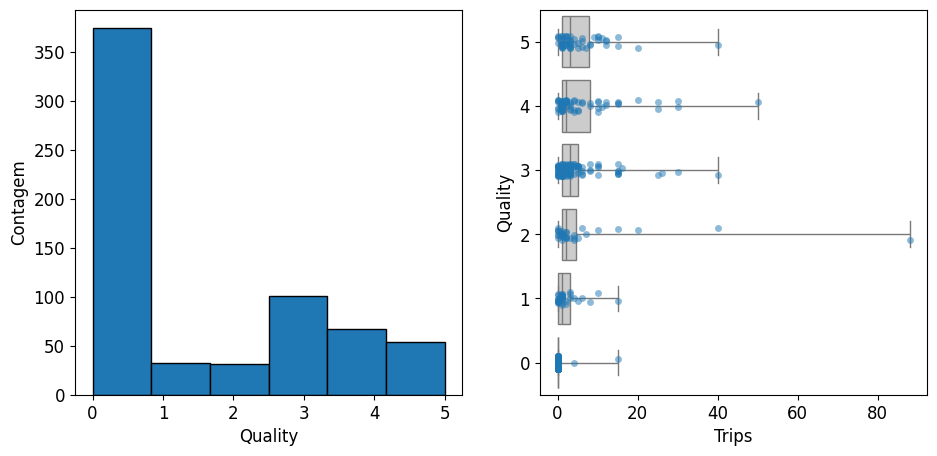

In [8]:
fig, axs = plt.subplots(1, 2, figsize = (11, 5))
axs[0].hist(dados["quality"], bins = 6)
#axs[1].scatter(dados["trips"], dados["quality"], alpha = 0.2)
sns.boxplot(dados, x = "trips", y = "quality", ax = axs[1], orient = "h", order = [5, 4, 3, 2, 1, 0], whis=[0, 100], color = ".8")
sns.stripplot(dados, x = "trips", y = "quality", ax = axs[1], orient = "h", order = [5, 4, 3, 2, 1, 0], alpha = 0.5)
axs[0].set_xlabel("Quality")
axs[0].set_ylabel("Contagem")
axs[1].set_xlabel("Trips")
axs[1].set_ylabel("Quality");

A média dessa variável é melhor interpretada quando calculamos sem contar valores de 0, já que indicam que o lago não foi avaliado. Nesse caso, temos média 3,28, indicando que há muitas avaliações intermediárias (confirmado pelo histograma).
 
A terceira variável, `ski`, também não é relacionada a fatores economicos/financeiros, e sim uma variável binária indicando se o entrevistado esquiava no lago enquanto passeava de barco. Naturalmente, para essa variável funcionar bem no modelo, precisamos convertê-la para valores numéricos (0 para não e 1 para sim). Analisando os histogramas, percebemos que pessoas que esquiam acabam fazendo mais viagens ao lago, sendo que a maioria dos valores pequenos de visitas são associados a pessoas que não visitaram tanto o lago.

In [9]:
#Tratamento adequado da variável
dados.loc[dados["ski"] == "no", "ski"] = 0
dados.loc[dados["ski"] == "yes", "ski"] = 1
dados["ski"] = dados["ski"].astype(int)

In [10]:
dados["ski"].value_counts()

ski
0    417
1    242
Name: count, dtype: int64

Text(0.5, 0, 'Trips (ski é 1)')

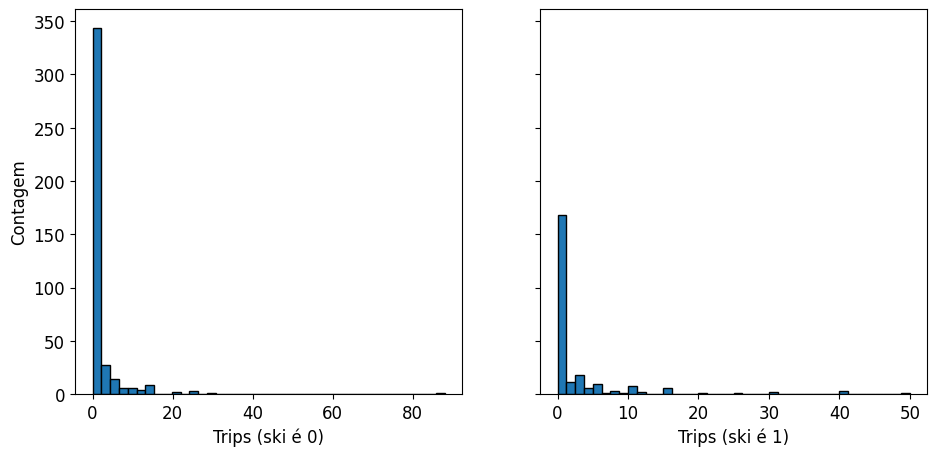

In [11]:
fig, axs = plt.subplots(1, 2, figsize = (11, 5), sharey = True)
axs[0].hist(dados.loc[dados["ski"] == 0, "trips"], bins = 40)
axs[1].hist(dados.loc[dados["ski"] == 1, "trips"], bins = 40)

axs[0].set_xlabel("Trips (ski é 0)")
axs[0].set_ylabel("Contagem")
axs[1].set_xlabel("Trips (ski é 1)")

A quarta variável, `income`, corresponde à renda familiar do entrevistado. Os valores não são exatos e estão divididos em intervalos de 1000 dólares, o que na prática faz ela ser uma variável categórica. Ainda assim, poderemos tratar como variável contínua na interpretação dos resultados, já que as divisões são baseadas em valores contínuos, e de certa forma valores intermediários entre as categorias têm interpretação válida. 

Essa variável não tem valores nulos ou faltantes, e suas estatísticas, em conjunto com seu histograma, indicam que não há outliers e que seu intervalo é bem definido (1 à 9).

In [12]:
f"Média: {float(dados['income'].mean())} | Mediana: {float(dados['income'].median())} | Variância: {float(dados['income'].var())} | Desvio Padrão: {float(dados['income'].std())}"

'Média: 3.8528072837632776 | Mediana: 3.0 | Variância: 3.429669158852641 | Desvio Padrão: 1.8519365968770747'

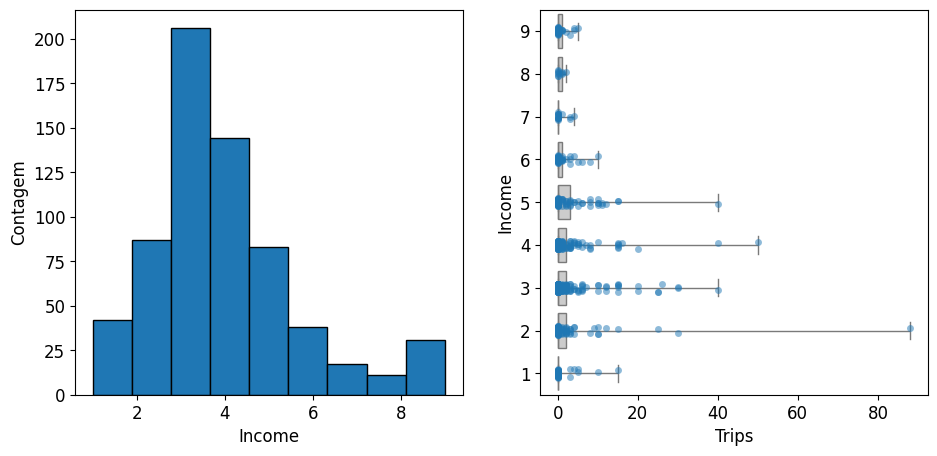

In [13]:
fig, axs = plt.subplots(1, 2, figsize = (11, 5))
axs[0].hist(dados["income"], bins = 9)
#axs[1].scatter(dados["trips"], dados["income"], alpha = 0.2))
sns.boxplot(dados, x = "trips", y = "income", ax = axs[1], orient = "h", order = [9, 8, 7, 6, 5, 4, 3, 2, 1], whis = [0, 100], color = ".8")
sns.stripplot(dados, x = "trips", y = "income", ax = axs[1], orient = "h", order = [9, 8, 7, 6, 5, 4, 3, 2, 1], alpha = 0.5)
axs[0].set_xlabel("Income")
axs[0].set_ylabel("Contagem")
axs[1].set_xlabel("Trips")
axs[1].set_ylabel("Income");

Observamos, pelo scatterplot, que as pessoas com mais visitas ao lago não necessariamente tem mais renda familiar.

A variável `userfee` também é uma variável binária, indicando se o dono de barco pagou uma taxa anual de uso do lago. Novamente se faz necessário dar um tratamento adequado para a variável, convertendo seus valores para 0 e 1. O que observamos do plot dos histogramas e das contagens é que apenas 13 entrevistados pagaram essa taxa, e o número de passeios que eles fizeram tem uma range ampla, mas acima de 3.

In [14]:
# Tratamento adequado da variável
dados.loc[dados["userfee"] == "no", "userfee"] = 0
dados.loc[dados["userfee"] == "yes", "userfee"] = 1
dados["userfee"] = dados["userfee"].astype(int)

In [15]:
dados["userfee"].value_counts()

userfee
0    646
1     13
Name: count, dtype: int64

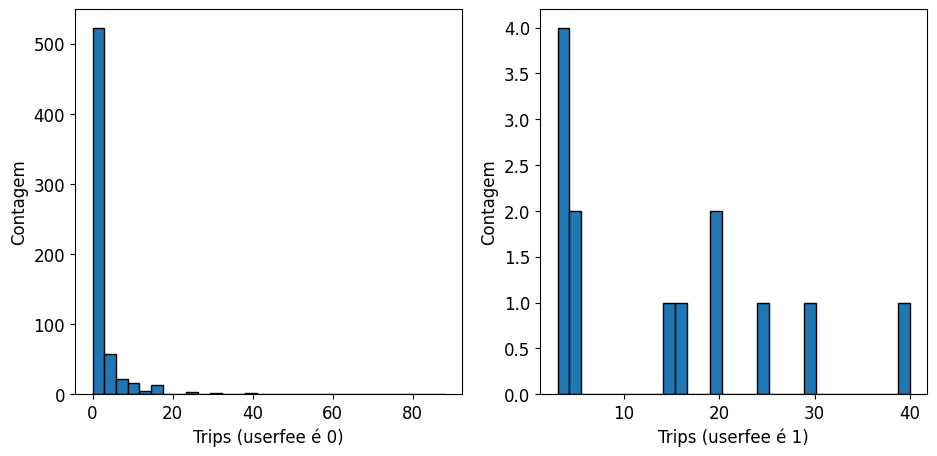

In [16]:
fig, axs = plt.subplots(1, 2, figsize = (11, 5))
axs[0].hist(dados.loc[dados["userfee"] == 0, "trips"], bins = 30)
axs[1].hist(dados.loc[dados["userfee"] == 1, "trips"], bins = 30)

axs[0].set_xlabel("Trips (userfee é 0)")
axs[0].set_ylabel("Contagem")
axs[1].set_xlabel("Trips (userfee é 1)")
axs[1].set_ylabel("Contagem");

As últimas variáveis do dataset tem funções semelhantes: `costC`, `costS` e `costH` indicam os **custos de oportunidade**, estimados em dólares, para cada entrevistado ir ou ao lago Conroe, ou ao lago Sommerville ou ao lago Houston, todos localizados no Texas com distância de carro entre eles abaixo de 2 horas. 

Em outras palavras, são estimativas de quanto a pessoa gastaria para ir a algum desses três lagos, acrescidos de quanto ela "deixaria de ganhar" indo aos outros. Esse é um conceito de economia bem conhecido, e é dado como melhor do que estimar apenas o gasto em dinheiro que ocorreria com a ida. A utilidade dessas variáveis em nossa regressão é entender se o custo de oportunidade de ir aos outros lagos influencia na quantidade de viagens ao lago de interesse. Porém, ao analisá-las, observamos que elas tem a distribuição muito próxima.

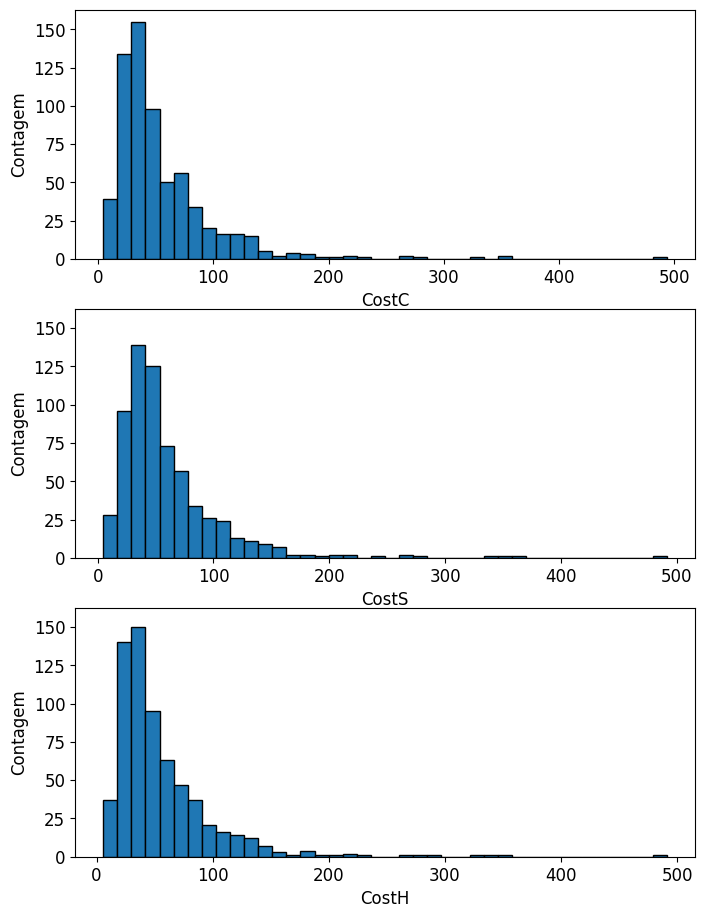

In [17]:
fig, axs = plt.subplots(3, 1, figsize = (8, 11), sharey = True)
axs[0].hist(dados["costC"], bins = 40)
axs[1].hist(dados["costS"], bins = 40)
axs[2].hist(dados["costH"], bins = 40)

axs[0].set_xlabel("CostC")
axs[0].set_ylabel("Contagem")
axs[1].set_xlabel("CostS")
axs[1].set_ylabel("Contagem")
axs[2].set_xlabel("CostH")
axs[2].set_ylabel("Contagem");

Podemos inspecionar melhor como essas variáveis se relacionam entre si e entre a variável de interesse plotando alguns scatterplots que mostrem as distribuições entre cada uma delas e delas com a variável de interesse.

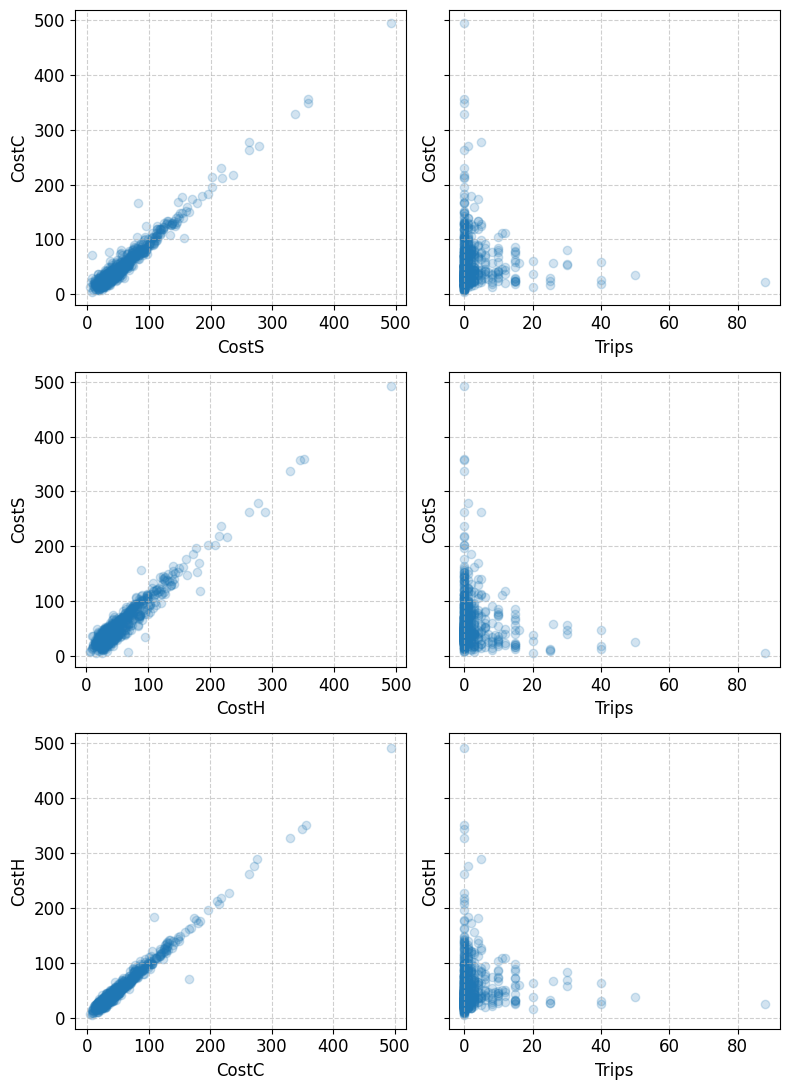

In [18]:
fig, axs = plt.subplots(3, 2, figsize = (8, 11), sharey = True)
axs[0, 0].scatter(dados["costS"], dados["costC"], alpha = 0.2)
axs[0, 0].grid(True, linestyle = "--", alpha = 0.6)
axs[1, 0].scatter(dados["costH"], dados["costS"], alpha = 0.2)
axs[1, 0].grid(True, linestyle = "--", alpha = 0.6)
axs[2, 0].scatter(dados["costC"], dados["costH"], alpha = 0.2)
axs[2, 0].grid(True, linestyle = "--", alpha = 0.6)

axs[0, 0].set_xlabel("CostS")
axs[0, 0].set_ylabel("CostC")
axs[1, 0].set_xlabel("CostH")
axs[1, 0].set_ylabel("CostS")
axs[2, 0].set_xlabel("CostC")
axs[2, 0].set_ylabel("CostH")

axs[0, 1].scatter(dados["trips"], dados["costC"], alpha = 0.2)
axs[0, 1].grid(True, linestyle = "--", alpha = 0.6)
axs[1, 1].scatter(dados["trips"], dados["costS"], alpha = 0.2)
axs[1, 1].grid(True, linestyle = "--", alpha = 0.6)
axs[2, 1].scatter(dados["trips"], dados["costH"], alpha = 0.2)
axs[2, 1].grid(True, linestyle = "--", alpha = 0.6)

axs[0, 1].set_xlabel("Trips")
axs[0, 1].set_ylabel("CostC")
axs[1, 1].set_xlabel("Trips")
axs[1, 1].set_ylabel("CostS")
axs[2, 1].set_xlabel("Trips")
axs[2, 1].set_ylabel("CostH")
fig.tight_layout()

Após inspecionar esses scatterplots, esperamos que:

- A correlação entre as variáveis de custo seja **muito** alta;
- A correlação delas com a variável de interesse seja baixa, já que a relação não parece ser linear.

Verificaremos isso fazendo uma matriz de correlação entre as variáveis do nosso dataset:

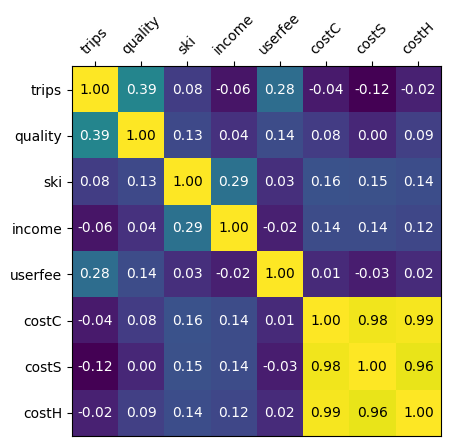

In [19]:
correlacao = dados.corr()
im = plt.imshow(dados.corr(), cmap = "viridis")
colunas = correlacao.columns.tolist()
plt.xticks(np.arange(len(colunas)), colunas, rotation = 45, fontsize = 10)
plt.yticks(np.arange(len(colunas)), colunas, fontsize = 10)
plt.tick_params(top = True, bottom = False, labeltop = True, labelbottom = False)

for i in range(len(colunas)):
    for j in range(len(colunas)):
        if correlacao.iloc[i, j] > 0.6:
            text = im.axes.text(j, i, f'{correlacao.iloc[i, j]:.2f}', ha = "center",  va = "center", color = "black", fontsize = 10)
        else:
            text = im.axes.text(j, i, f'{correlacao.iloc[i, j]:.2f}', ha = "center",  va = "center", color = "white", fontsize = 10)

Como a matriz mostra, as três variáveis de custo têm correlações maiores do que 95% entre elas. Além disso, a variável de custo ao lago de interesse (Sommerville) tem correlação com a variável de interesse maior em módulo do que a das outras duas, mas ainda assim com módulo muito baixo. Isso indica que, entre elas, essa pode ser a mais importante para o modelo. Além da matriz de correlação, uma métrica muito útil para definirmos se essas variáveis entrarão na regressão é o Fator de Inflação de Variância (em inglês, VIF).

In [20]:
colunas = ["quality", "ski", "income", "userfee", "costC", "costS", "costH"]
VIFs = []
for index, coluna in enumerate(colunas):
    VIF = variance_inflation_factor(dados[colunas], index)
    VIFs.append(VIF)
pd.DataFrame(
    {"coluna": colunas,
     "VIF": VIFs}
).T

,0,1,2,3,4,5,6
coluna,quality,ski,income,userfee,costC,costS,costH
VIF,1.717989,1.792726,3.190647,1.065486,131.397142,61.328934,93.752282


Todas elas tem VIF muito maior do que os recomendados 5 pontos para a remoção de um modelo. Introduzir elas no modelo pode causar uma instabilidade numérica em sua avaliação. Mesmo se tratando de um GLM, que usa métodos iterativos para maximizar a verossimilhança e não calcula a matriz $(X^T X)^{-1}$, ainda assim ter variáveis muito próximas da colinearidade prejudica os cálculos da convergência do modelo.

Todas essas análises sobre as últimas variáveis levam à uma preocupação quanto a contribuição delas para o modelo que será ajustado. Existe a possibilidade delas introduzirem mais problemas do que ajudar na construção do modelo, levando a conclusões errôneas.

Uma possível forma de mitigar os efeitos negativos ao ajuste que a inclusão dessas variáveis traria é remover duas delas e deixar apenas uma. Nessa abordagem, o significado prático das variáveis leva à conclusão de que seria melhor manter a varíavel `costS` e remover as outras duas, já que o custo que mais influenciaria a ida ao lago seria o dele mesmo.

Porém, vale observar que essa abordagem tira do modelo uma capacidade que pode ser interessante: inferir se a diferença entre essa variáveis influencia na decisão (ou seja, se um lago ter um custo menor de ida que o outro muda a quantidade de viagens que uma pessoa fez a ele). Mantendo apenas uma variável, o potencial de comparação é perdido. Ao mesmo tempo, manter duas delas segue fazendo o VIF delas ser alto:

In [21]:
colunas = ["quality", "ski", "income", "userfee", "costS", "costH"]
VIFs = []
for index, coluna in enumerate(colunas):
    VIF = variance_inflation_factor(dados[colunas], index)
    VIFs.append(VIF)
    #print("Coluna", coluna, "tem VIF igual à", VIF)
pd.DataFrame(
    {"coluna": colunas,
     "VIF": VIFs}
).T

,0,1,2,3,4,5
coluna,quality,ski,income,userfee,costS,costH
VIF,1.712896,1.785848,3.115096,1.062281,42.90048,40.775716


Pensando em manter o potencial de interpretação que essas variáveis podem trazer e ao mesmo tempo evitar os problemas de colinearidade, é possível fazer uma transformação que mantenha informações úteis para inferência e remova as colunas sem muita perda de informação. Tendo em vista o significado das variáveis e visando não aumentar muito a complexidade da base, uma transformação possível é introduzir uma coluna `isCheapest`, com valores binários:
- 1 (verdadeiro) caso `costS` < `costC` e `costS` < `costH`.
- 0 (falso) caso contrário.

In [22]:
dados["isCheapest"] = (dados[["costC", "costS", "costH"]].idxmin(axis=1) == "costS").astype(int)
colunas = ["quality", "ski", "income", "userfee", "costS", "isCheapest"]
VIFs = []
for index, coluna in enumerate(colunas):
    VIF = variance_inflation_factor(dados[colunas], index)
    VIFs.append(VIF)
#    print("Coluna", coluna, "tem VIF igual à", VIF)
pd.DataFrame(
    {"coluna": colunas,
     "VIF": VIFs}
).T

,0,1,2,3,4,5
coluna,quality,ski,income,userfee,costS,isCheapest
VIF,1.899121,1.785035,3.042713,1.081909,2.352996,1.554768


In [23]:
dados["isCheapest"].value_counts()

isCheapest
0    505
1    154
Name: count, dtype: int64

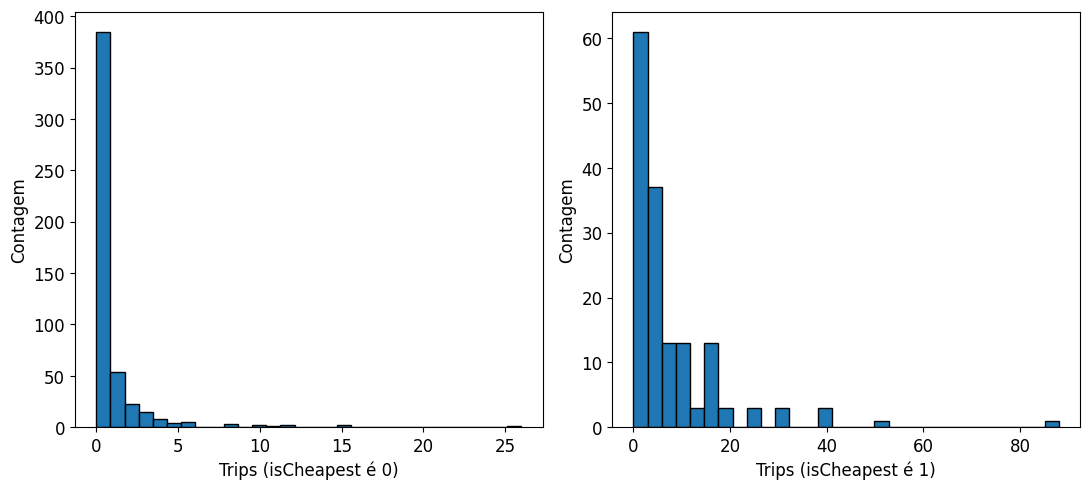

In [24]:
fig, axs = plt.subplots(1, 2, figsize = (11, 5))
axs[0].hist(dados.loc[dados["isCheapest"] == 0, "trips"], bins = 30)
axs[1].hist(dados.loc[dados["isCheapest"] == 1, "trips"], bins = 30)

axs[0].set_xlabel("Trips (isCheapest é 0)")
axs[0].set_ylabel("Contagem")
axs[1].set_xlabel("Trips (isCheapest é 1)")
axs[1].set_ylabel("Contagem")


fig.tight_layout()

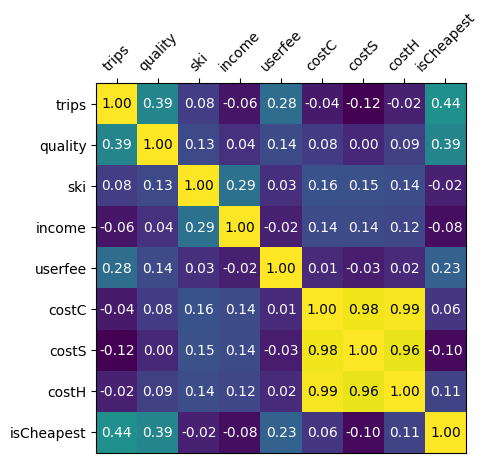

In [25]:
correlacao = dados.corr()
im = plt.imshow(dados.corr(), cmap = "viridis")
colunas = correlacao.columns.tolist()
plt.xticks(np.arange(len(colunas)), colunas, rotation = 45, fontsize = 10)
plt.yticks(np.arange(len(colunas)), colunas, fontsize = 10)
plt.tick_params(top = True, bottom = False, labeltop = True, labelbottom = False)

for i in range(len(colunas)):
    for j in range(len(colunas)):
        if correlacao.iloc[i, j] > 0.6:
            text = im.axes.text(j, i, f'{correlacao.iloc[i, j]:.2f}', ha = "center",  va = "center", color = "black", fontsize = 10)
        else:
            text = im.axes.text(j, i, f'{correlacao.iloc[i, j]:.2f}', ha = "center",  va = "center", color = "white", fontsize = 10)

A análise dessa nova variável parece mostrar que ela pode ser uma boa escolha para o ajuste do modelo, por mitigar os problemas causados pelas outras sem "jogar fora" totalmente o potêncial informativo que elas tinham. As distribuições do número de viagens para entradas em que ela é verdadeira mostra que ela pode ser bem impactante na decisão de uma pessoa de visitar ou não o lago. A correlação de 44% também corrobora com esse pensamento.

Para por a prova o que foi levantado nesta análise, é possível ajustar mais de um modelo, com diferentes escolhas de variáveis, e analisar qual se ajusta melhor aos dados.

## 2. Ajustando modelos Poisson

Aqui, serão ajustados 3 modelos lineares generalizados da família Poisson, devido à natureza da variável dependente. A função de ligação desse modelo é o logarítmo natural $log(.)$. O ajuste será feito de maneira frequentista, usando o Estimador de Máxima Verossimilhança. Devido à natureza desse modelo (e dos GLMs num geral), o ajuste é feito por métodos numéricos iterativos, que convergem para a solução de máxima verossimilhança.

Todos eles serão ajustados com as variáveis `quality`, `ski`, `income` e `userfee`, pois nenhuma delas apresentou sinais de que não tinha influência nenhuma na variável de interesse (a variável `quality` tinha algumas entradas suspeitas, mas a correlação dela com a variável dependente pode ser um sinal de que ela será uma boa preditora). Já as variáveis de custo terão um tratamento especial: o primeiro modelo será ajustado com as três variáveis, o segundo apenas com a `costS` e o terceiro com a `costS` e a nova variável `isCheapest`.

In [26]:
dependente = dados["trips"]
independentes_1 = sm.add_constant(dados[["quality", "ski", "income", "userfee", "costC", "costS", "costH"]])
modelo_1 = sm.GLM(dependente, independentes_1, family = sm.families.Poisson())
resultados_1 = modelo_1.fit()
resultados_1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  trips   No. Observations:                  659
Model:                            GLM   Df Residuals:                      651
Model Family:                 Poisson   Df Model:                            7
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1529.4
Date:                Mon, 02 Jun 2025   Deviance:                       2305.8
Time:                        11:46:38   Pearson chi2:                 4.10e+03
No. Iterations:                     8   Pseudo R-squ. (CS):             0.9789
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2650      0.094      2.827      0.005       0.081       0.449
quality        0.4717      0.017     27.602      0.000       0.438       0.505
ski            0.4182      0.057      7.313      0.000       0.306       0.530
income        -0.1113      0.020     -5.683      0.000      -0.150      -0.073
userfee        0.8982      0.079     11.371      0.000       0.743       1.053
costC         -0.0034      0.003     -1.100      0.271      -0.010       0.003
costS         -0.0425      0.002    -25.466      0.000      -0.046      -0.039
costH          0.0361      0.003     13.335      0.000       0.031       0.041
==============================================================================
"""

In [27]:
resultados_1.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
===============================================================
Model:              GLM              AIC:            3074.8626 
Link Function:      Log              BIC:            -1919.6755
Dependent Variable: trips            Log-Likelihood: -1529.4   
Date:               2025-06-02 11:46 LL-Null:        -2801.4   
No. Observations:   659              Deviance:       2305.8    
Df Model:           7                Pearson chi2:   4.10e+03  
Df Residuals:       651              Scale:          1.0000    
Method:             IRLS                                       
----------------------------------------------------------------
            Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
----------------------------------------------------------------
const       0.2650    0.0937    2.8274  0.0047   0.0813   0.4487
quality     0.4717    0.0171   27.6016  0.0000   0.4382   0.5052
ski         0.4182    0.0572    7.3126  0.0000   0.3061   0.5303
income     -0.1113    0.0196   -5.6831  0.0000  -0.1497  -0.0729
userfee     0.8982    0.0790   11.3713  0.0000   0.7434   1.0530
costC      -0.0034    0.0031   -1.1000  0.2713  -0.0095   0.0027
costS      -0.0425    0.0017  -25.4657  0.0000  -0.0458  -0.0393
costH       0.0361    0.0027   13.3353  0.0000   0.0308   0.0414
===============================================================

"""

Observamos que o modelo com todas as variáveis apresenta um pseudo-$R^2_{CS}$ de aproximadamente $0,98$. Essa métrica é o pseudo-$R^2$ de Cox e Snell, usado em modelos lineares generalizados e parametrizado como $R^2_{CS} = 1 - exp\{\frac{2}{n}(ln(L_0) - ln(L_M))\}$. Ele é uma generalização do $R^2$ já conhecido para modelos que não são ajustados por mínimos quadrados, e sim por maxima verossimilhança. 

Nos GLM, ele não é interpretado como a porcentagem da variância explicada, e sim como uma melhoria no ajuste do modelo (tanto que ele pode nem chegar a um para regressões logísticas), e ainda mantém a propriedade de quanto maior, melhor.

Podemos ver que todos as estimativas de regressores, com excessão do associado à variável `costC`, são estatísticamente significativos. Esse resultado pode parecer bom, mas é preciso tomar cuidado e se ter em mente que o VIF das variáveis de custo eram bem altos, e que isso pode interferir nas estatísticas e testes do modelo.

In [28]:
independentes_2 = sm.add_constant(dados[["quality", "ski", "income", "userfee", "costS"]])
modelo_2 = sm.GLM(dependente, independentes_2, family = sm.families.Poisson())
resultados_2 = modelo_2.fit()
resultados_2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
===============================================================
Model:              GLM              AIC:            3452.5604 
Link Function:      Log              BIC:            -1550.9591
Dependent Variable: trips            Log-Likelihood: -1720.3   
Date:               2025-06-02 11:46 LL-Null:        -2801.4   
No. Observations:   659              Deviance:       2687.5    
Df Model:           5                Pearson chi2:   5.82e+03  
Df Residuals:       653              Scale:          1.0000    
Method:             IRLS                                       
----------------------------------------------------------------
            Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
----------------------------------------------------------------
const       0.5861    0.0919    6.3771  0.0000   0.4060   0.7662
quality     0.5408    0.0159   33.9241  0.0000   0.5096   0.5721
ski         0.4542    0.0565    8.0440  0.0000   0.3435   0.5649
income     -0.1578    0.0195   -8.0930  0.0000  -0.1961  -0.1196
userfee     1.1015    0.0799   13.7860  0.0000   0.9449   1.2581
costS      -0.0153    0.0010  -15.0975  0.0000  -0.0173  -0.0133
===============================================================

"""

In [29]:
resultados_2.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
===============================================================
Model:              GLM              AIC:            3452.5604 
Link Function:      Log              BIC:            -1550.9591
Dependent Variable: trips            Log-Likelihood: -1720.3   
Date:               2025-06-02 11:46 LL-Null:        -2801.4   
No. Observations:   659              Deviance:       2687.5    
Df Model:           5                Pearson chi2:   5.82e+03  
Df Residuals:       653              Scale:          1.0000    
Method:             IRLS                                       
----------------------------------------------------------------
            Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
----------------------------------------------------------------
const       0.5861    0.0919    6.3771  0.0000   0.4060   0.7662
quality     0.5408    0.0159   33.9241  0.0000   0.5096   0.5721
ski         0.4542    0.0565    8.0440  0.0000   0.3435   0.5649
income     -0.1578    0.0195   -8.0930  0.0000  -0.1961  -0.1196
userfee     1.1015    0.0799   13.7860  0.0000   0.9449   1.2581
costS      -0.0153    0.0010  -15.0975  0.0000  -0.0173  -0.0133
===============================================================

"""

Removendo as variáveis de custo que não são referentes ao lago Sommerville, observamos uma piora em algumas métricas: o AIC e Deviance são maiores (o que é indesejável) e o pseudo-$R^2$ é menor, ainda que por pouca diferença. Também observamos que a verossimilhança é menor, indicando uma menor compatibilidade entre os dados reais e as previsões. 

Esse aumento pode indicar que a remoção das variáveis trouxe uma perda de poder preditivo, mesmo que estabilizasse a convergência do modelo e suas estatísticas. 

In [30]:
independentes_3 = sm.add_constant(dados[["quality", "ski", "income", "userfee", "costS", "isCheapest"]])
modelo_3 = sm.GLM(dependente, independentes_3, family = sm.families.Poisson())
resultados_3 = modelo_3.fit()
resultados_3.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  trips   No. Observations:                  659
Model:                            GLM   Df Residuals:                      652
Model Family:                 Poisson   Df Model:                            6
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1434.1
Date:                Mon, 02 Jun 2025   Deviance:                       2115.1
Time:                        11:46:38   Pearson chi2:                 4.04e+03
No. Iterations:                     6   Pseudo R-squ. (CS):             0.9842
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.4750      0.108     -4.418      0.000      -0.686      -0.264
quality        0.4259      0.018     24.026      0.000       0.391       0.461
ski            0.4920      0.055      8.882      0.000       0.383       0.601
income        -0.0768      0.019     -4.099      0.000      -0.113      -0.040
userfee        0.6083      0.081      7.508      0.000       0.450       0.767
costS         -0.0093      0.001     -9.947      0.000      -0.011      -0.007
isCheapest     1.5037      0.067     22.541      0.000       1.373       1.634
==============================================================================
"""

In [31]:
resultados_3.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
               Results: Generalized linear model
===============================================================
Model:              GLM              AIC:            2882.1280 
Link Function:      Log              BIC:            -2116.9007
Dependent Variable: trips            Log-Likelihood: -1434.1   
Date:               2025-06-02 11:46 LL-Null:        -2801.4   
No. Observations:   659              Deviance:       2115.1    
Df Model:           6                Pearson chi2:   4.04e+03  
Df Residuals:       652              Scale:          1.0000    
Method:             IRLS                                       
----------------------------------------------------------------
             Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
----------------------------------------------------------------
const       -0.4750    0.1075  -4.4181  0.0000  -0.6857  -0.2643
quality      0.4259    0.0177  24.0258  0.0000   0.3911   0.4606
ski          0.4920    0.0554   8.8816  0.0000   0.3835   0.6006
income      -0.0768    0.0187  -4.0987  0.0000  -0.1135  -0.0401
userfee      0.6083    0.0810   7.5079  0.0000   0.4495   0.7671
costS       -0.0093    0.0009  -9.9470  0.0000  -0.0111  -0.0074
isCheapest   1.5037    0.0667  22.5405  0.0000   1.3729   1.6344
===============================================================

"""

O terceiro modelo apresenta todas as métricas melhores: seu AIC e sua Deviance são menores que dos outros, indicando que mesmo com menos features, o modelo pode se ajustar melhor aos dados. O pseudo-$R^2$ é maior, também reforçando a ideia de que muito da variância foi explicada. 

É possível ver que todas as estimativas de parâmetros  são estatísticamente significantes, e para esse modelo esses resultados são mais confiáveis, principalmente quando se leva em conta que o VIF de todas as variáveis independentes usadas era menor do que 5. A log verossimilhança também é menor, o que é mais um bom sinal.

Para auxiliar na análise da bondade de ajuste desses modelos, podemos fazer plots de valor predito por resíduo de Pearson. Os resíduos de Pearson são definidos por $r_i^P = \frac{y_i - \hat\mu_i}{sqrt(\hat\mu_i)}$ e são padronizados, levando em conta qual seria a variância para um preditor da média. Por não estarmos lidando com um modelo linear, não é possível esperar que esses resíduos se distribuam uniformemente, mas é esperado, pela padronização, que eles fiquem distribuidos perto de 0 e a que a grande maioria fique no range (-2, 2).

O objetivo dessa padronização é se adaptar ao fato de que, na regressão Poisson, a variância dos dados aumenta junto com a média, e tornar esses resíduos mais uniformes mesmo com o aumento da média (que aqui é a previsão do modelo). 

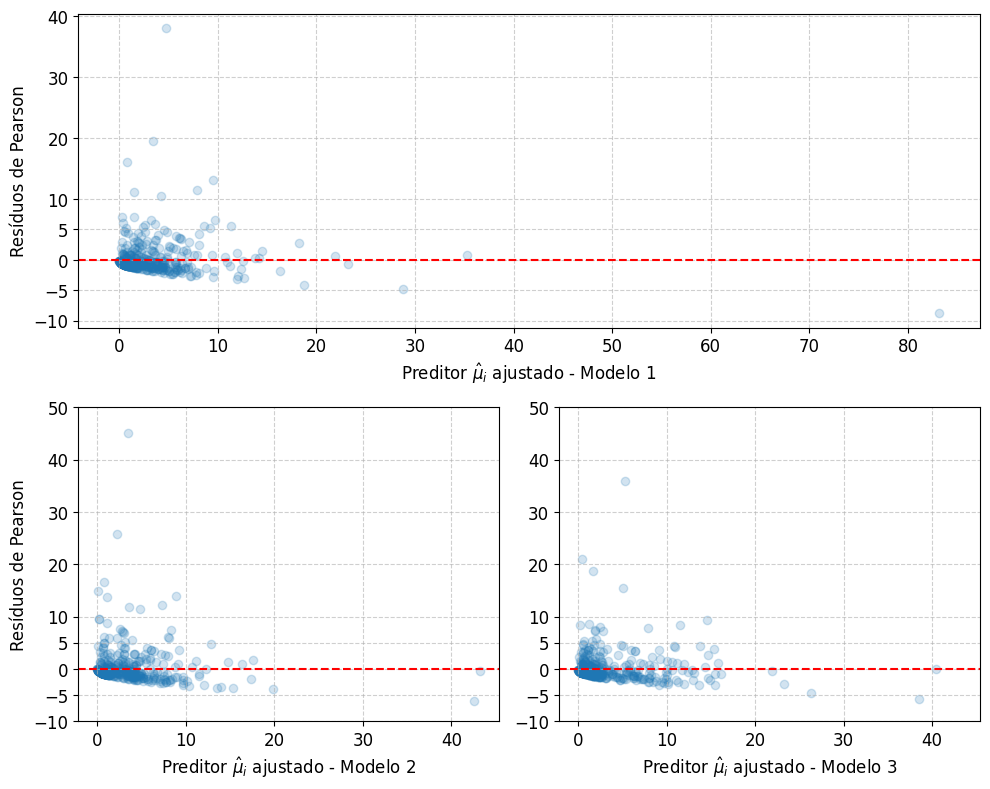

In [32]:
fig = plt.figure(figsize=(10, 8))
ax1 = plt.subplot(2, 1, 1)
ax1.scatter(resultados_1.fittedvalues, resultados_1.resid_pearson, alpha = 0.2)
ax1.axhline(y = 0, color = 'r', linestyle = '--')
ax1.grid(True, linestyle = "--", alpha = 0.6)
ax1.set_xlabel("Preditor $\\hat \\mu_i$ ajustado - Modelo 1")
ax1.set_ylabel("Resíduos de Pearson")


plt.xticks([0, 10, 20, 30, 40, 50, 60, 70, 80])
plt.yticks([-10, -5, 0, 5, 10, 20, 30, 40])


ax2 = plt.subplot(2, 2, 3)
ax2.scatter(resultados_2.fittedvalues, resultados_2.resid_pearson, alpha = 0.2)
ax2.axhline(y = 0, color = 'r', linestyle = '--')
ax2.grid(True, linestyle = "--", alpha = 0.6)
ax2.set_xlabel("Preditor $\\hat \\mu_i$ ajustado - Modelo 2")
ax2.set_ylabel("Resíduos de Pearson")

ax3 = plt.subplot(2, 2, 4, sharex = ax2, sharey = ax2)
ax3.scatter(resultados_3.fittedvalues, resultados_3.resid_pearson, alpha = 0.2)
ax3.axhline(y = 0, color = 'r', linestyle = '--')
ax3.grid(True, linestyle = "--", alpha = 0.6)
ax3.set_xlabel("Preditor $\\hat \\mu_i$ ajustado - Modelo 3")
plt.yticks([-10, -5, 0, 5, 10, 20, 30, 40, 50])

fig.tight_layout()

Dos plots, três observações saltam aos olhos:

- O primeiro e o segundo modelos tem resíduos padronizados que parecem ser menos dispersos a medida em que o valor do preditor aumenta, o que não acontece tão claramente com o terceiro modelo, que tem a distribuição desses resíduos mais consistente mesmo com as mudanças do preditor;
- Todos os modelos tem vários dos resíduos longe do 0, indo contra o que seria esperado da distribuição desses resíduos, que idealmente teriam desvio padrão 1;
- Os resíduos menores que 0 parecem se concentrar mais, enquanto os maiores que zero são mais espalhados e amplos.

A primeira observação corrobora com a ideia de que o terceiro modelo conseguiu se ajustar melhor aos dados, mantendo uma distribuição dos resíduos de Pearson mais próxima do que se espera. Já a segunda observação é um forte indício de que todos os modelos sofreram de sobredispersão.

Os resíduos estarem muito espalhados, mais do que o esperado, indica que os valores reais estão muito distantes das previsões do modelo. Essa distância pode se dar pela sobredispersão: o modelo não foi pensado para lidar com dados com variância maior do que a média, e então não faz previsões de acordo com a variância real. 

É possível conduzir um teste estatístico formal para atestar se há ou não sobredispersão no modelo. Para conduzir este teste, é necessário escolher um dos modelos. Devido às métricas apresentadas serem melhores e a distribuição dos resíduos de Pearson serem mais próximas do esperado, o teste será conduzido com o terceiro modelo, que faz uso da nova variável criada para o dataset.

## 3. Testando a sobredispersão

Para esse teste, queremos saber se rejeitamos ou não a hipotese nula: para uma parametrização da variância como $Var(Y) = \mu + \alpha \mu^2$, a hipotese nula é $H_0: \alpha = 0$. Os resultados da regressão de $Z_i$ em $\hat\mu_i$ obtidos foram:

In [33]:
Z = (np.power(dados["trips"] - resultados_3.fittedvalues, 2) - dados["trips"])/resultados_3.fittedvalues

In [34]:
modelo_teste = sm.OLS(Z, resultados_3.fittedvalues)
resultado_teste = modelo_teste.fit()
resultado_teste.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.010
Model:                            OLS   Adj. R-squared (uncentered):              0.009
Method:                 Least Squares   F-statistic:                              6.888
Date:                Mon, 02 Jun 2025   Prob (F-statistic):                     0.00888
Time:                        11:46:39   Log-Likelihood:                         -3572.5
No. Observations:                 659   AIC:                                      7147.
Df Residuals:                     658   BIC:                                      7151.
Df Model:                           1                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             1.2061      0.460      2.624      0.009       0.304       2.109
==============================================================================
Omnibus:                     1515.886   Durbin-Watson:                   1.038
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          5268993.461
Skew:                          19.789   Prob(JB):                         0.00
Kurtosis:                     439.262   Cond. No.                         1.00
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

Estatísticamente, obtivemos uma estatística de teste t igual à $2,624$, cujo p-valor é $0,009$. Esse resultado indica significância estatística, já que o p-valor está abaixo de 0,05. Logo, rejeitamos a hipótese $H_0$, levando a conclusão de que existe sobredispersão. O resultado do teste formal condiz com o que observamos nos resíduos dos modelos na etapa anterior.

Tendo conhecimento da sobredispersão, não é vantajoso usar um modelo que não é pensado para lidar com ela para fazer inferências e interpretações sobre os dados. Por isso, é importante usar modelos que são pensados para lidar com esse tipo de fenômeno.

## 4. Modelo Binomial Negativo

O modelo em questão, que consegue levar a sobredispersão em conta em seu ajuste, é um modelo da família Binomial Negativa. Esse modelo, assim como o de Poisson, modela dados cujo domínio é o conjunto dos números naturais. A parametrização desse modelo lembra o teste que foi feito acima:

$$E[Y_i|X_i] = \mu_i = \exp\{x_i^T\beta\}$$

$$Var(Y_i|X_i) = \mu_i + \alpha \mu_i^2$$

Essa variância é o que modela a sobredispersão: o valor $\alpha$ é estimado junto com o $\beta$, e então o ajuste leva em conta a sobredispersão, e o parâmetro $\alpha$ ganha uma estimativa $\hat\alpha$ com intervalo de confiança. Como estamos lidando com dados inteiros positivos, e como os dados de contagem geralmente abrangem várias magnitudes (como vimos no nosso dataset também), a função de link deste modelo é o logarítmo natural, função inversa da exponencial. 

In [35]:
modelo_nb = sm.NegativeBinomial(dependente, independentes_3, loglike_method = "nb2")
resultados_nb = modelo_nb.fit()
resultados_nb.summary()

Optimization terminated successfully.
         Current function value: 1.269525
         Iterations: 32
         Function evaluations: 39
         Gradient evaluations: 39


/home/pedro/Modelos/Faculdade/venv/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:3379: RuntimeWarning: divide by zero encountered in log
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)
/home/pedro/Modelos/Faculdade/venv/lib/python3.13/site-packages/statsmodels/discrete/discrete_model.py:3379: RuntimeWarning: invalid value encountered in multiply
  llf = coeff + size*np.log(prob) + endog*np.log(1-prob)


<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                  trips   No. Observations:                  659
Model:               NegativeBinomial   Df Residuals:                      652
Method:                           MLE   Df Model:                            6
Date:                Mon, 02 Jun 2025   Pseudo R-squ.:                  0.2142
Time:                        11:46:39   Log-Likelihood:                -836.62
converged:                       True   LL-Null:                       -1064.7
Covariance Type:            nonrobust   LLR p-value:                 2.260e-95
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.6855      0.228     -7.393      0.000      -2.132      -1.239
quality        0.7132      0.046     15.582      0.000       0.624       0.803
ski            0.6324      0.153      4.143      0.000       0.333       0.932
income        -0.0595      0.045     -1.317      0.188      -0.148       0.029
userfee        0.7272      0.364      1.996      0.046       0.013       1.441
costS         -0.0057      0.002     -2.899      0.004      -0.010      -0.002
isCheapest     1.7376      0.156     11.154      0.000       1.432       2.043
alpha          1.4219      0.150      9.454      0.000       1.127       1.717
==============================================================================
"""

In [36]:
resultados_nb.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: NegativeBinomial
=================================================================
Model:              NegativeBinomial Pseudo R-squared: 0.214     
Dependent Variable: trips            AIC:              1689.2337 
Date:               2025-06-02 11:46 BIC:              1725.1595 
No. Observations:   659              Log-Likelihood:   -836.62   
Df Model:           6                LL-Null:          -1064.7   
Df Residuals:       652              LLR p-value:      2.2595e-95
Converged:          1.0000           Scale:            1.0000    
Method:             MLE                                          
------------------------------------------------------------------
               Coef.   Std.Err.     z     P>|z|    [0.025   0.975]
------------------------------------------------------------------
const         -1.6855    0.2280  -7.3926  0.0000  -2.1324  -1.2387
quality        0.7132    0.0458  15.5817  0.0000   0.6235   0.8029
ski            0.6324    0.1526   4.1430  0.0000   0.3332   0.9315
income        -0.0595    0.0452  -1.3166  0.1880  -0.1480   0.0291
userfee        0.7272    0.3642   1.9965  0.0459   0.0133   1.4411
costS         -0.0057    0.0020  -2.8992  0.0037  -0.0096  -0.0019
isCheapest     1.7376    0.1558  11.1538  0.0000   1.4323   2.0430
alpha          1.4219    0.1504   9.4545  0.0000   1.1271   1.7167
=================================================================

"""

In [37]:
#modelo_nb1 = sm.NegativeBinomial(dependente, independentes_3, loglike_method = "nb1")
#resultados_nb1 = modelo_nb1.fit()
#resultados_nb1.summary()

Observamos que após o fit, o resultado contém as estimativas para os regressores e também para o parâmetro da sobredispersão. A métrica do pseudo-$R^2$ se mostrou bem menor em relação ao que estava sendo visto na regressão Poisson, mas isso é esperado: o Modelo Poisson ignorava a sobredispersão e ela não era levada em conta para fazer o ajuste e nem calcular as métricas. Já o modelo Binomial Negativa, por levar em conta a sobredispersão, incorpora o ajuste à esse fenômeno em sua verossimilhança e por consequência no cálculo de métricas como o pseudo-$R^2$. 

Isso se reflete em um valor mais baixo, mas mais real e útil para comparação de possíveis modelos com essa parametrização (ele não está jogado para perto do 1, o que pode facilitar comparações).

Text(0, 0.5, 'Resíduos de Pearson')

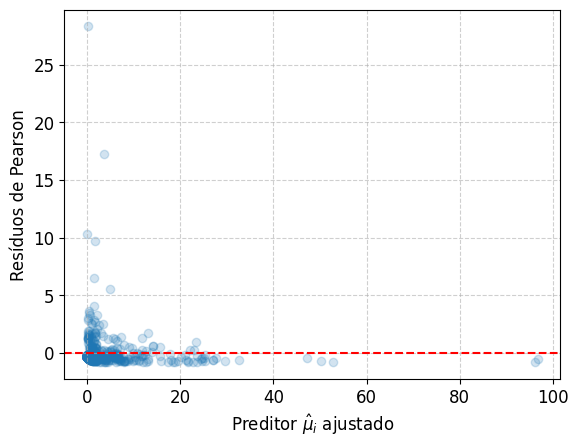

In [38]:
plt.scatter(np.exp(resultados_nb.fittedvalues), resultados_nb.resid_pearson, alpha = 0.2)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.grid(True, linestyle = "--", alpha = 0.6)
plt.xlabel("Preditor $\\hat \\mu_i$ ajustado")
plt.ylabel("Resíduos de Pearson")

Observando o scatter plot dos resíduos contra os valores ajustados, vemos que agora os resíduos se concentram dentro do range (-2, 2), ao contrários dos resíduos dos modelos Poisson treinados, que eram muito mais dispersos. Isso indica que o modelo conseguiu lidar melhor com a sobredispersão dos dados, fazendo previsões mais "amplas". Esse resultado é positivo, já que se deseja modelar o comportamento real dos dados e todos os seus fenômenos intrinsecos.

É preciso ressaltar, porém, que os resíduos ainda apresentam comportamentos estranhos. Assim como ocorreu com os modelos Poisson, os resíduos negativos se concentram no intervalo esperado, enquanto alguns positivos são muito espalhados. Esse último comportamento é especialmente predominante em predições que foram próximas de 0. Esse comportamento leva a conclusão de que:

- O modelo está errando mais para baixo do que para cima, ou seja, está predizendo muitos valores abaixo do esperado.
- Algumas dessas previsões tem erros que jogam elas para outras casas de magnitude abaixo do esperado.

Esses são sintomas de que o modelo está predizendo valores abaixo dos que deveria predizer muito frequentemente, fugindo do comportamento que se esperaria ver normalmente.

## Questão 5 - Modelo inflado de zeros

In [39]:
modelo_zi = sm.ZeroInflatedPoisson(dependente, independentes_3)
resultados_zi = modelo_zi.fit()
resultados_zi.summary()

Optimization terminated successfully.
         Current function value: 2.109287
         Iterations: 26
         Function evaluations: 31
         Gradient evaluations: 31


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedPoisson Regression Results                    
===============================================================================
Dep. Variable:                   trips   No. Observations:                  659
Model:             ZeroInflatedPoisson   Df Residuals:                      652
Method:                            MLE   Df Model:                            6
Date:                 Mon, 02 Jun 2025   Pseudo R-squ.:                  0.2068
Time:                         11:46:39   Log-Likelihood:                -1390.0
converged:                        True   LL-Null:                       -1752.5
Covariance Type:             nonrobust   LLR p-value:                2.579e-153
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -0.5157      0.129     -3.994      0.000      -0.769      -0.263
const             0.3076      0.126      2.450      0.014       0.062       0.554
quality           0.2961      0.022     13.669      0.000       0.254       0.339
ski               0.5072      0.057      8.826      0.000       0.395       0.620
income           -0.0760      0.020     -3.826      0.000      -0.115      -0.037
userfee           0.5418      0.081      6.717      0.000       0.384       0.700
costS            -0.0100      0.001    -10.233      0.000      -0.012      -0.008
isCheapest        1.2825      0.072     17.754      0.000       1.141       1.424
=================================================================================
"""

In [40]:
resultados_zi.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: ZeroInflatedPoisson
=====================================================================
Model:              ZeroInflatedPoisson Pseudo R-squared: 0.207      
Dependent Variable: trips               AIC:              2796.0403  
Date:               2025-06-02 11:46    BIC:              2831.9661  
No. Observations:   659                 Log-Likelihood:   -1390.0    
Df Model:           6                   LL-Null:          -1752.5    
Df Residuals:       652                 LLR p-value:      2.5787e-153
Converged:          1.0000              Scale:            1.0000     
Method:             MLE                                              
----------------------------------------------------------------------
                  Coef.   Std.Err.     z      P>|z|    [0.025   0.975]
----------------------------------------------------------------------
inflate_const    -0.5157    0.1291   -3.9943  0.0001  -0.7688  -0.2627
const             0.3076    0.1256    2.4503  0.0143   0.0616   0.5537
quality           0.2961    0.0217   13.6692  0.0000   0.2537   0.3386
ski               0.5072    0.0575    8.8264  0.0000   0.3946   0.6198
income           -0.0760    0.0199   -3.8259  0.0001  -0.1149  -0.0371
userfee           0.5418    0.0807    6.7168  0.0000   0.3837   0.6999
costS            -0.0100    0.0010  -10.2328  0.0000  -0.0120  -0.0081
isCheapest        1.2825    0.0722   17.7544  0.0000   1.1410   1.4241
=====================================================================

"""

Text(0, 0.5, 'Resíduos de Pearson')

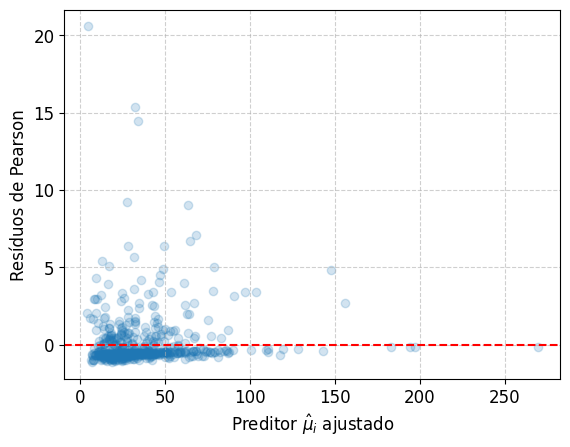

In [41]:
plt.scatter(resultados_zi.fittedvalues, resultados_zi.resid_pearson, alpha = 0.2)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.grid(True, linestyle = "--", alpha = 0.6)
plt.xlabel("Preditor $\\hat \\mu_i$ ajustado")
plt.ylabel("Resíduos de Pearson")

In [42]:
modelo_zinb = sm.ZeroInflatedNegativeBinomialP(dependente, independentes_3)
resultados_zinb = modelo_zinb.fit()
resultados_zinb.summary()

         Current function value: 1.269550
         Iterations: 35
         Function evaluations: 38
         Gradient evaluations: 38


/home/pedro/Modelos/Faculdade/venv/lib/python3.13/site-packages/scipy/optimize/_optimize.py:1313: OptimizeWarning: Maximum number of iterations has been exceeded.
  res = _minimize_bfgs(f, x0, args, fprime, callback=callback, **opts)
/home/pedro/Modelos/Faculdade/venv/lib/python3.13/site-packages/statsmodels/base/model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/home/pedro/Modelos/Faculdade/venv/lib/python3.13/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '
/home/pedro/Modelos/Faculdade/venv/lib/python3.13/site-packages/statsmodels/base/model.py:595: HessianInversionWarning: Inverting hessian failed, no bse or cov_params available
  warnings.warn('Inverting hessian failed, no bse or cov_params '


<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                             trips   No. Observations:                  659
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                      652
Method:                                      MLE   Df Model:                            6
Date:                           Mon, 02 Jun 2025   Pseudo R-squ.:                  0.2142
Time:                                   11:46:39   Log-Likelihood:                -836.63
converged:                                 False   LL-Null:                       -1064.7
Covariance Type:                       nonrobust   LLR p-value:                 2.297e-95
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const   -10.1471     14.738     -0.688      0.491     -39.033      18.739
const            -1.6842      0.228     -7.393      0.000      -2.131      -1.238
quality           0.7132      0.046     15.590      0.000       0.624       0.803
ski               0.6353      0.153      4.163      0.000       0.336       0.934
income           -0.0599      0.045     -1.328      0.184      -0.148       0.029
userfee           0.7821      0.371      2.109      0.035       0.055       1.509
costS            -0.0057      0.002     -2.903      0.004      -0.010      -0.002
isCheapest        1.7320      0.156     11.134      0.000       1.427       2.037
alpha             1.4186      0.150      9.466      0.000       1.125       1.712
=================================================================================
"""

In [43]:
resultados_zinb.summary2()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Results: ZeroInflatedNegativeBinomialP
==============================================================================
Model:              ZeroInflatedNegativeBinomialP Pseudo R-squared: 0.214     
Dependent Variable: trips                         AIC:              1691.2665 
Date:               2025-06-02 11:46              BIC:              1731.6830 
No. Observations:   659                           Log-Likelihood:   -836.63   
Df Model:           6                             LL-Null:          -1064.7   
Df Residuals:       652                           LLR p-value:      2.2966e-95
Converged:          0.0000                        Scale:            1.0000    
Method:             MLE                                                       
---------------------------------------------------------------------------------
                  Coef.      Std.Err.       z       P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const    -10.1471     14.7382    -0.6885    0.4911    -39.0335    18.7393
const             -1.6842      0.2278    -7.3931    0.0000     -2.1307    -1.2377
quality            0.7132      0.0457    15.5900    0.0000      0.6235     0.8029
ski                0.6353      0.1526     4.1631    0.0000      0.3362     0.9344
income            -0.0599      0.0451    -1.3276    0.1843     -0.1484     0.0285
userfee            0.7821      0.3708     2.1090    0.0349      0.0553     1.5089
costS             -0.0057      0.0020    -2.9034    0.0037     -0.0096    -0.0019
isCheapest         1.7320      0.1556    11.1345    0.0000      1.4271     2.0369
alpha              1.4186      0.1499     9.4664    0.0000      1.1249     1.7123
==============================================================================

"""

Text(0, 0.5, 'Resíduos de Pearson')

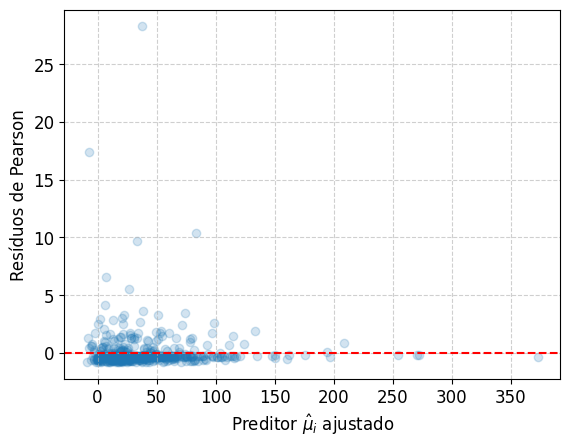

In [44]:
plt.scatter(resultados_zinb.fittedvalues, resultados_zinb.resid_pearson, alpha = 0.2)
plt.axhline(y = 0, color = 'r', linestyle = '--')
plt.grid(True, linestyle = "--", alpha = 0.6)
plt.xlabel("Preditor $\\hat \\mu_i$ ajustado")
plt.ylabel("Resíduos de Pearson")

In [45]:
pd.Series(resultados_zinb.resid_pearson > 0).value_counts()

False    551
True     108
Name: count, dtype: int64

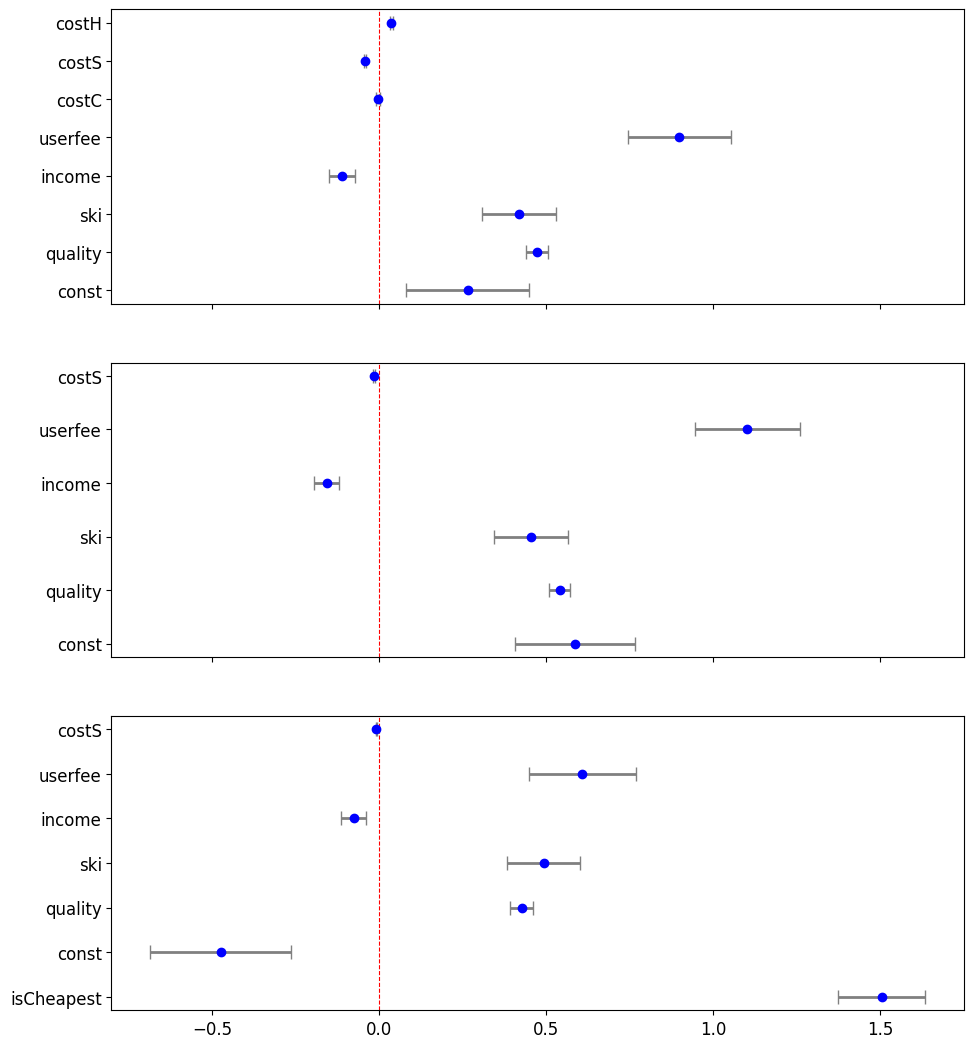

In [46]:
#Plot auxiliar, não entrou para o relatório final
fig, axs = plt.subplots(3, figsize = (11, 13), sharex = True)
coefficients = resultados_1.params
conf_int = resultados_1.conf_int(alpha = 0.05) # IC de 95%
plot_df = pd.DataFrame({
    'Coefficient': coefficients,
    'Lower CI': conf_int[0],
    'Upper CI': conf_int[1]
})
plot_df = plot_df.drop('Intercept', errors = 'ignore')
plot_df = plot_df.sort_values(by = 'Coefficient')
plot_df = plot_df.reindex(["const", "quality", "ski", "income", "userfee", "costC", "costS", "costH"])
axs[0].errorbar(
    x = plot_df['Coefficient'],
    y = plot_df.index, # Nomes das variáveis no eixo Y
    xerr = [plot_df['Coefficient'] - plot_df['Lower CI'], plot_df['Upper CI'] - plot_df['Coefficient']],
    fmt = 'o',          # Formato do marcador (bolinha)
    color = 'blue',
    capsize = 5,        # Tamanho das 'tampas' nas barras de erro
    ecolor = 'gray',    # Cor das barras de erro
    elinewidth = 2,     # Largura das linhas de erro
    markerfacecolor = 'blue',
    markeredgecolor = 'blue'
)
axs[0].axvline(x = 0, color = 'red', linestyle = '--', linewidth = 0.8)

coefficients = resultados_2.params
conf_int = resultados_2.conf_int(alpha = 0.05) # IC de 95%
plot_df = pd.DataFrame({
    'Coefficient': coefficients,
    'Lower CI': conf_int[0],
    'Upper CI': conf_int[1]
})
plot_df = plot_df.drop('Intercept', errors = 'ignore')
plot_df = plot_df.sort_values(by = 'Coefficient')
plot_df = plot_df.reindex(["const", "quality", "ski", "income", "userfee", "costS"])
axs[1].errorbar(
    x = plot_df['Coefficient'],
    y = plot_df.index, # Nomes das variáveis no eixo Y
    xerr = [plot_df['Coefficient'] - plot_df['Lower CI'], plot_df['Upper CI'] - plot_df['Coefficient']],
    fmt = 'o',          # Formato do marcador (bolinha)
    color = 'blue',
    capsize = 5,        # Tamanho das 'tampas' nas barras de erro
    ecolor = 'gray',    # Cor das barras de erro
    elinewidth = 2,     # Largura das linhas de erro
    markerfacecolor = 'blue',
    markeredgecolor = 'blue'
)
axs[1].axvline(x = 0, color = 'red', linestyle = '--', linewidth = 0.8)

coefficients = resultados_3.params
conf_int = resultados_3.conf_int(alpha = 0.05) # IC de 95%
plot_df = pd.DataFrame({
    'Coefficient': coefficients,
    'Lower CI': conf_int[0],
    'Upper CI': conf_int[1]
})
plot_df = plot_df.drop('Intercept', errors = 'ignore')
plot_df = plot_df.sort_values(by = 'Coefficient')
plot_df = plot_df.reindex(["isCheapest", "const", "quality", "ski", "income", "userfee", "costS"])
axs[2].errorbar(
    x = plot_df['Coefficient'],
    y = plot_df.index, # Nomes das variáveis no eixo Y
    xerr = [plot_df['Coefficient'] - plot_df['Lower CI'], plot_df['Upper CI'] - plot_df['Coefficient']],
    fmt = 'o',          # Formato do marcador (bolinha)
    color = 'blue',
    capsize = 5,        # Tamanho das 'tampas' nas barras de erro
    ecolor = 'gray',    # Cor das barras de erro
    elinewidth = 2,     # Largura das linhas de erro
    markerfacecolor = 'blue',
    markeredgecolor = 'blue'
)
axs[2].axvline(x = 0, color = 'red', linestyle = '--', linewidth = 0.8)